This  taken  from 

https://github.com/lighthouse-labs/applications-of-ml/blob/main/XGBoost%20Regression%20Assignment%20(Submit%20to%20Kaggle).ipynb


- https://www.kaggle.com/code/carlmcbrideellis/an-introduction-to-xgboost-regression
- https://www.kaggle.com/code/dansbecker/xgboost/notebook

In this assignment we will apply XGBoost Regression techniques to predict house prices, based on the famous Kaggle Dataset https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

Step 1 is to download the dataset.

In [110]:
#=========================================================================
# load up the libraries
#=========================================================================
import pandas  as pd
import numpy   as np
import xgboost as xgb

#=========================================================================
# read in the data
#=========================================================================
train_data = pd.read_csv('house-prices-advanced-regression-techniques/train.csv',index_col=0)
test_data  = pd.read_csv('house-prices-advanced-regression-techniques/test.csv',index_col=0)

### <center style="background-color:Gainsboro; width:60%;">Feature selection</center>
The purpose of feature selection, as the name suggests, is to only model the most pertinent and important features, thus reducing the computational overhead, and also to alleviate the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). The following are a number of notebooks covering techniques to achieve said goal, all of which use the House Prices data as an example:

* [Feature selection using the Boruta-SHAP package](https://www.kaggle.com/carlmcbrideellis/feature-selection-using-the-boruta-shap-package)
* [Recursive Feature Elimination (RFE) example](https://www.kaggle.com/carlmcbrideellis/recursive-feature-elimination-rfe-example)
* [House Prices: Permutation Importance example](https://www.kaggle.com/carlmcbrideellis/house-prices-permutation-importance-example)
* [Feature importance using the LASSO](https://www.kaggle.com/carlmcbrideellis/feature-importance-using-the-lasso)

In this assignment, we shall use all of the numerical columns, and ignore the categorical features. To encode the categorical features one can use for example [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html). 

Our first task is to do Feature Exploration and Selection. 

In [99]:
test_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [29]:
from IPython.display import display

# Set display options to show all columns and rows without truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [100]:
import pandas as pd

column_names = []
data_types = []

# Iterate through the columns and their data types
for column, dtype in train_data.dtypes.items():
    column_names.append(column)
    data_types.append(str(dtype))

# Create a new df
col_names_dypes = pd.DataFrame({
    'Column Name': column_names,
    'Data Type': data_types
})

col_names_dypes.head()

,Column Name,Data Type
0,MSSubClass,int64
1,MSZoning,object
2,LotFrontage,float64
3,LotArea,int64
4,Street,object


In [3]:
# Int features
int_features = col_names_dypes['Column Name'][col_names_dypes['Data Type']=='int64']
int_features=int_features.tolist()

float_features = col_names_dypes['Column Name'][col_names_dypes['Data Type']=='float64']
float_features=float_features.tolist()
train_data['GarageYrBlt'].describe()

test = train_data[train_data['LotFrontage'] % 1 == 0]
test['LotFrontage']

Id
1       65.0
2       80.0
3       68.0
4       60.0
5       84.0
        ... 
1456    62.0
1457    85.0
1458    66.0
1459    68.0
1460    75.0
Name: LotFrontage, Length: 1201, dtype: float64

In [13]:
float_features

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [101]:
features=['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
            'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 
            '1stFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 
            'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr',  'Fireplaces', 
            'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
            'EnclosedPorch',  'PoolArea', 'YrSold']

In [102]:

#===========================================================================
#===========================================================================
X_train       = train_data[features]
y_train       = train_data["SalePrice"]
X_test       = test_data[features]


In [16]:
from BorutaShap import BorutaShap

# If no model is selected default is the Random Forest
# If classification is True it is a classification problem
Feature_Selector = BorutaShap(importance_measure='shap', classification=False)

Feature_Selector.fit(X=X_train, y=y_train, n_trials=50, random_state=9898)

  0%|          | 0/50 [00:00<?, ?it/s]

14 attributes confirmed important: ['TotalBsmtSF', 'YearBuilt', 'GarageCars', 'LotArea', 'BsmtFinSF1', 'Fireplaces', 'OverallCond', 'GrLivArea', 'OpenPorchSF', 'WoodDeckSF', 'GarageArea', 'OverallQual', 'YearRemodAdd', '1stFlrSF']
9 attributes confirmed unimportant: ['BsmtFinSF2', 'BedroomAbvGr', 'BsmtHalfBath', 'YrSold', 'HalfBath', 'BsmtFullBath', 'LowQualFinSF', 'EnclosedPorch', 'PoolArea']
0 tentative attributes remains: []


In [111]:
selected_features=['TotalBsmtSF', 'YearBuilt', 'GarageCars', 'LotArea', 'BsmtFinSF1', 'Fireplaces', 'OverallCond', 'GrLivArea', 'OpenPorchSF', 'WoodDeckSF', 'GarageArea', 'OverallQual', 'YearRemodAdd', '1stFlrSF']
X_train       = train_data[selected_features]
y_train       = train_data["SalePrice"]
X_test      = test_data[selected_features]

In [43]:
count_same_years = (X_train['YearRemodAdd'] == X_train['YearBuilt']).sum()
count_same_years

764

In [45]:
correlation = df['OpenPorchSF'].corr(df['WoodDeckSF'])

# Print the correlation coefficient
print("Correlation between OverallQual and OverallCond:", correlation)

Correlation between OverallQual and OverallCond: 0.058660608565887264


### <center style="background-color:Gainsboro; width:60%;">Feature engineering</center>
As mentioned, one aspect of feature engineering is the creation of new features out of existing features. A simple example would be to create a new feature which is the sum of the number of bathrooms in the house:

In [112]:
for df in (X_train, X_test):
    df["Outdoor_Feature_DF"] = df["OpenPorchSF"] + df["WoodDeckSF"]



In [105]:
# which features have zeros?
zero_counts = (X_train == 0).sum()

# Display or use the zero counts
print("Number of zeros for each feature:")
print(zero_counts)

Number of zeros for each feature:
TotalBsmtSF            37
YearBuilt               0
GarageCars             81
LotArea                 0
BsmtFinSF1            467
Fireplaces            690
OverallCond             0
GrLivArea               0
OpenPorchSF           656
WoodDeckSF            761
GarageArea             81
OverallQual             0
YearRemodAdd            0
1stFlrSF                0
Outdoor_Feature_DF    394
dtype: int64


In [113]:
#dropping finished basement sf in favour of area_with_finished_basement to reduce 0 count

#dropping wooddecksf and OpenPorchSF in favour of Outdoor_Feature_DF to reduce 0 count

#dropping area_with_finished_basement as it is similar to GrLivingArea

columns_to_drop = ['BsmtFinSF1', 'OpenPorchSF', 'WoodDeckSF']

# Drop the specified columns from X_train and X_test
X_train = X_train.drop(columns=columns_to_drop, axis=1)
X_test = X_test.drop(columns=columns_to_drop, axis=1)

In [63]:
zero_counts = (X_train == 0).sum()

# Display or use the zero counts
print("Number of zeros for each feature:")
print(zero_counts)

Number of zeros for each feature:
TotalBsmtSF                            37
YearBuilt                               0
GarageCars                             81
LotArea                                 0
Fireplaces                            690
OverallCond                             0
GrLivArea                               0
GarageArea                             81
OverallQual                             0
YearRemodAdd                            0
1stFlrSF                                0
Outdoor_Feature_DF                    394
area_with_finished_basement             0
log_transformed_Outdoor_Feature_DF    394
dtype: int64


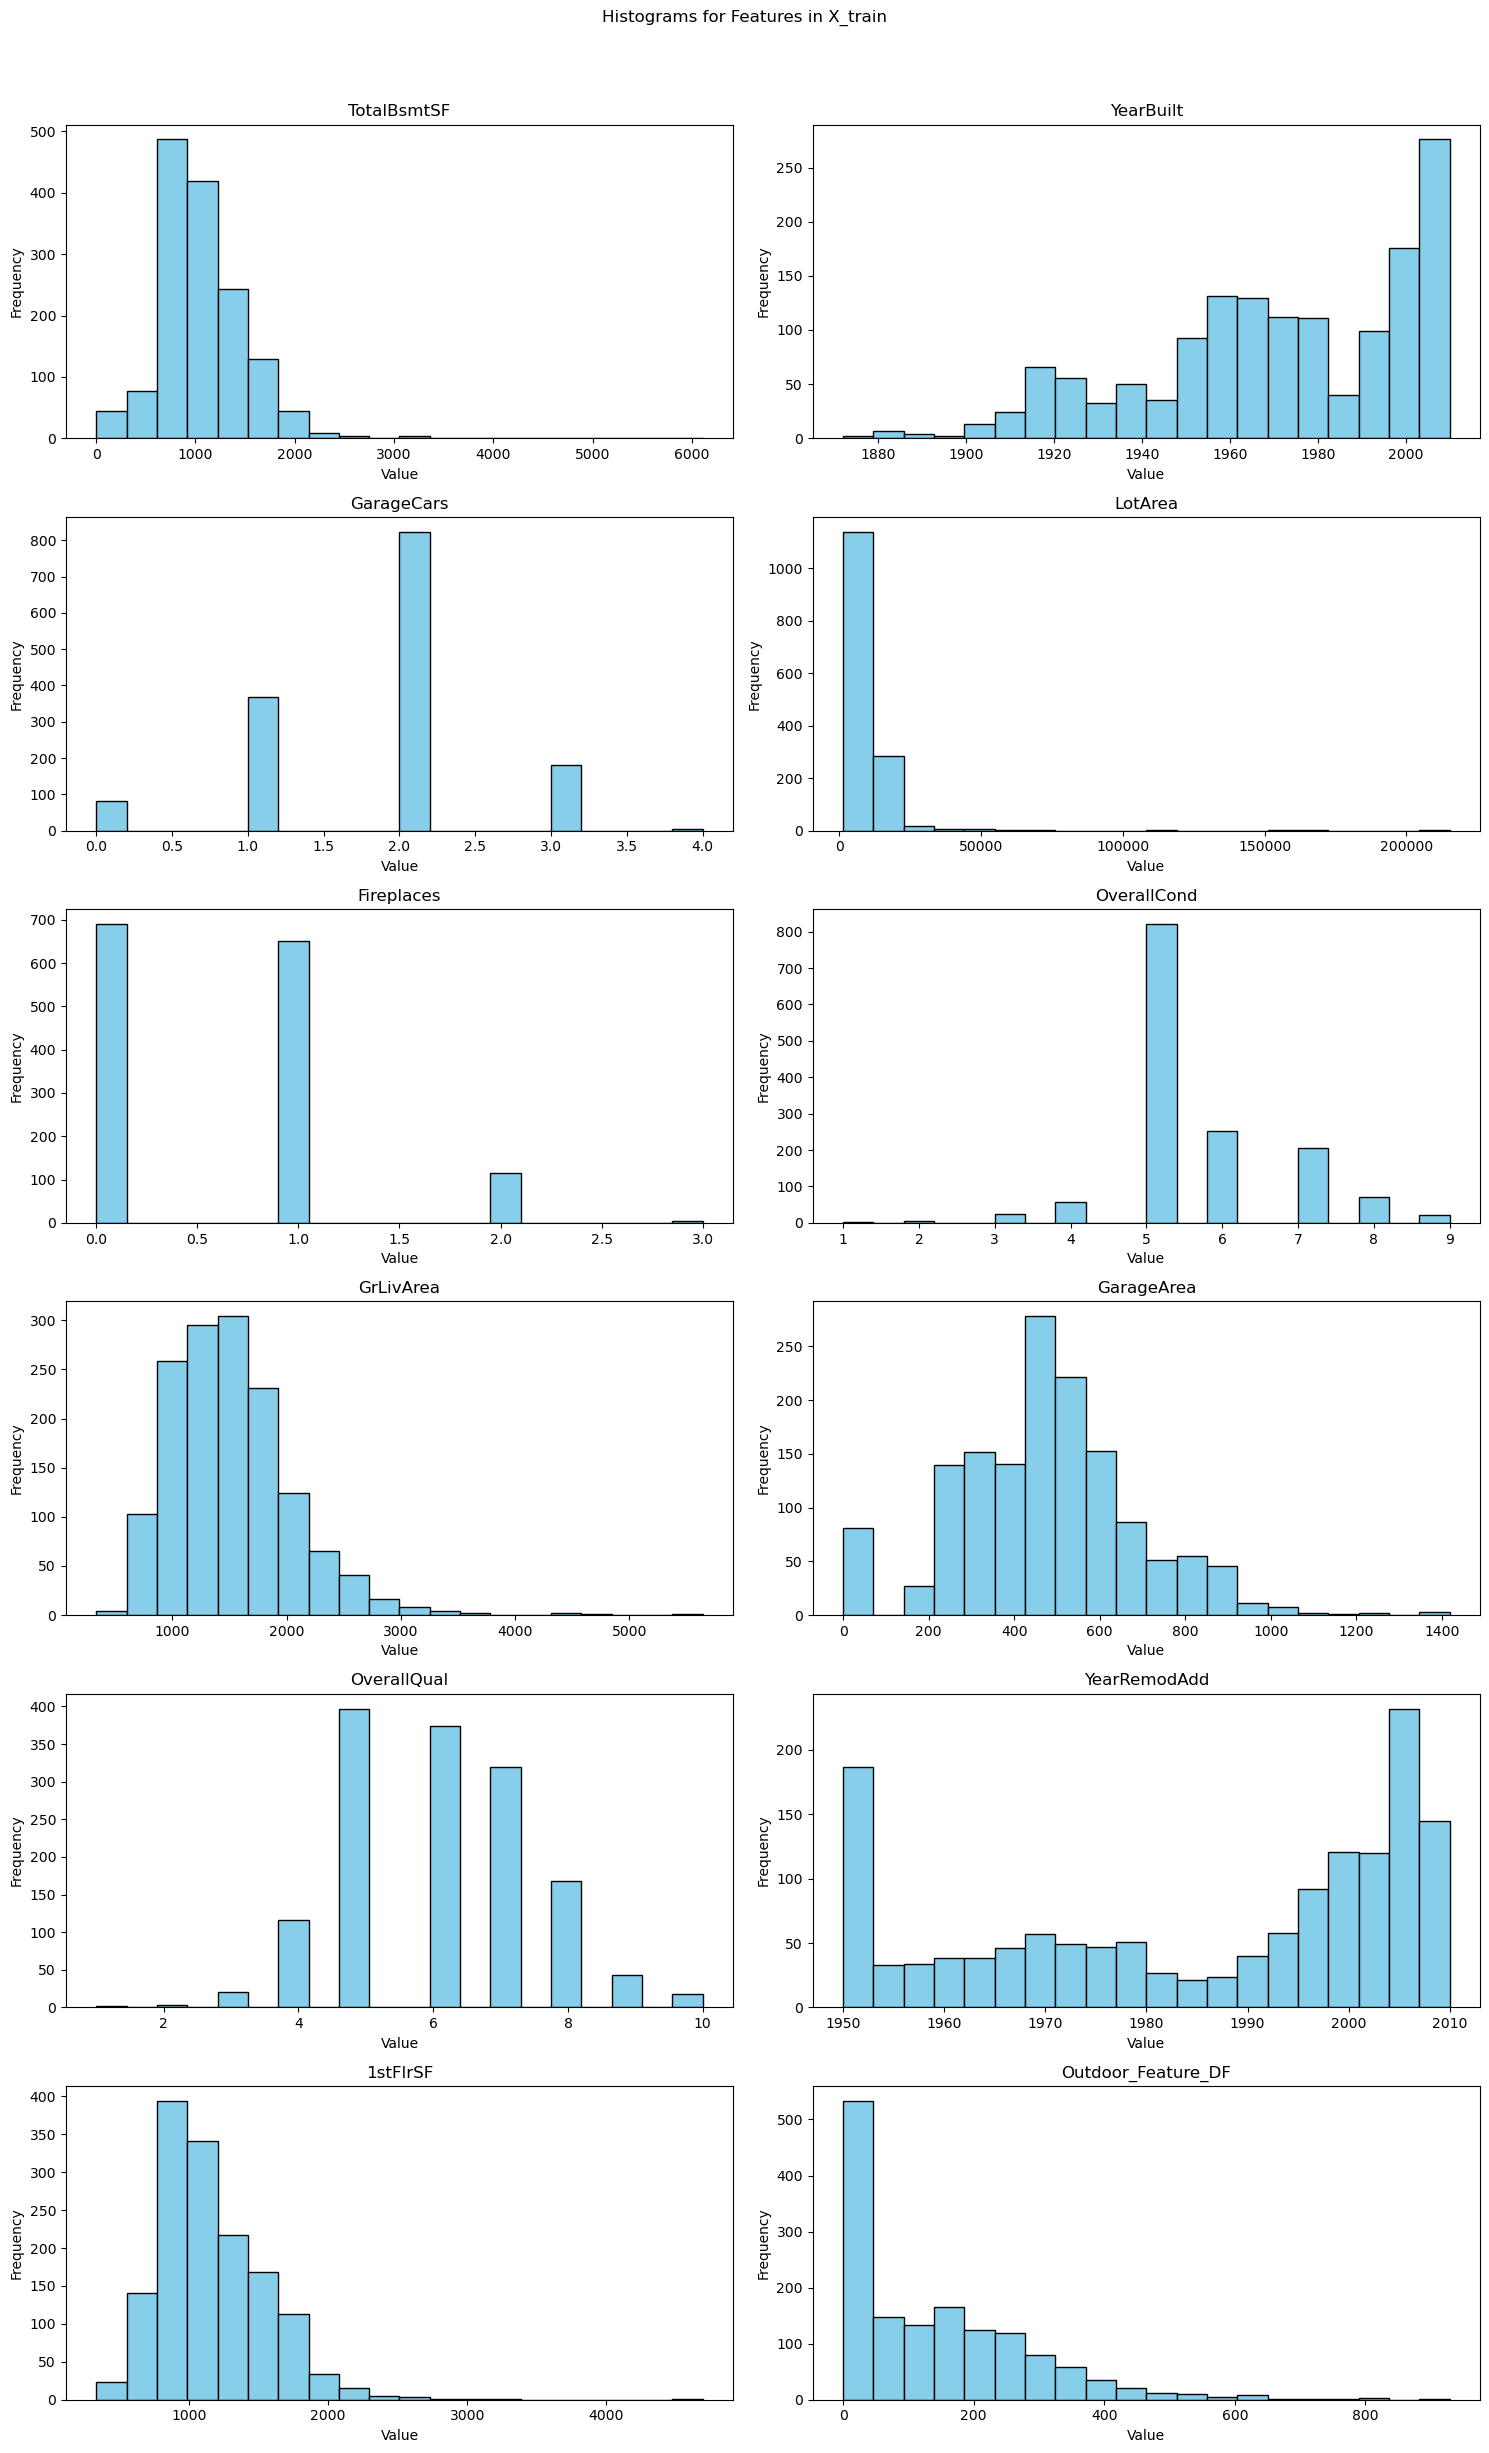

In [107]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming X_train is your feature matrix (a pandas DataFrame)
# X_train = ...

# Set the layout for subplots based on the number of features
num_features = X_train.shape[1]
num_rows = (num_features + 1) // 2  # Ensure at least two plots per row
num_cols = 2

# Create a figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
fig.suptitle('Histograms for Features in X_train', y=1.02)

# Flatten the 2D array of subplots for easier indexing
axes = axes.flatten()

# Plot histograms for each feature
for i in range(num_features):
    axes[i].hist(X_train.iloc[:, i], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(X_train.columns[i])
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()


In [64]:
# some variables are left skewed and have many zeros
X_train.columns

Index(['TotalBsmtSF', 'YearBuilt', 'GarageCars', 'LotArea', 'Fireplaces',
       'OverallCond', 'GrLivArea', 'GarageArea', 'OverallQual', 'YearRemodAdd',
       '1stFlrSF', 'Outdoor_Feature_DF', 'area_with_finished_basement',
       'log_transformed_Outdoor_Feature_DF'],
      dtype='object')

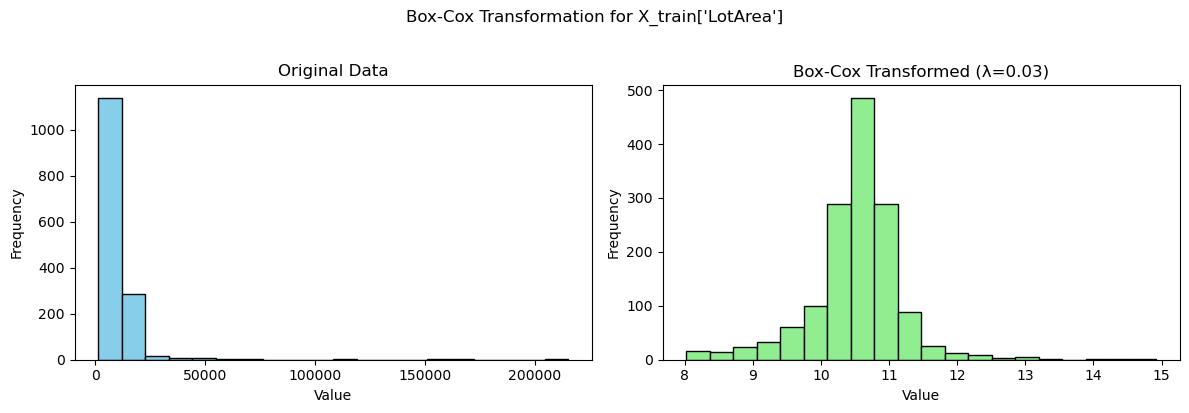

In [58]:
#Lot Area is left skewed without many zeros, performing a box cox transformation 
from scipy.stats import boxcox
import matplotlib.pyplot as plt

# Assuming X_train is your DataFrame containing 'BsmtFinSF1'
# X_train = ...

# Extract the column to be transformed
bsmtfin_sf1 = X_train['LotArea']

# Apply Box-Cox transformation
bsmtfin_sf1_boxcox, lambda_value = boxcox(bsmtfin_sf1 + 1)  # Adding 1 to avoid issues with zero values

# Plot histograms for original and transformed data
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Box-Cox Transformation for X_train[\'LotArea\']', y=1.02)

# Plot histogram for original data
axes[0].hist(bsmtfin_sf1, bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Original Data')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

# Plot histogram for Box-Cox transformed data
axes[1].hist(bsmtfin_sf1_boxcox, bins=20, color='lightgreen', edgecolor='black')
axes[1].set_title(f'Box-Cox Transformed (λ={lambda_value:.2f})')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()


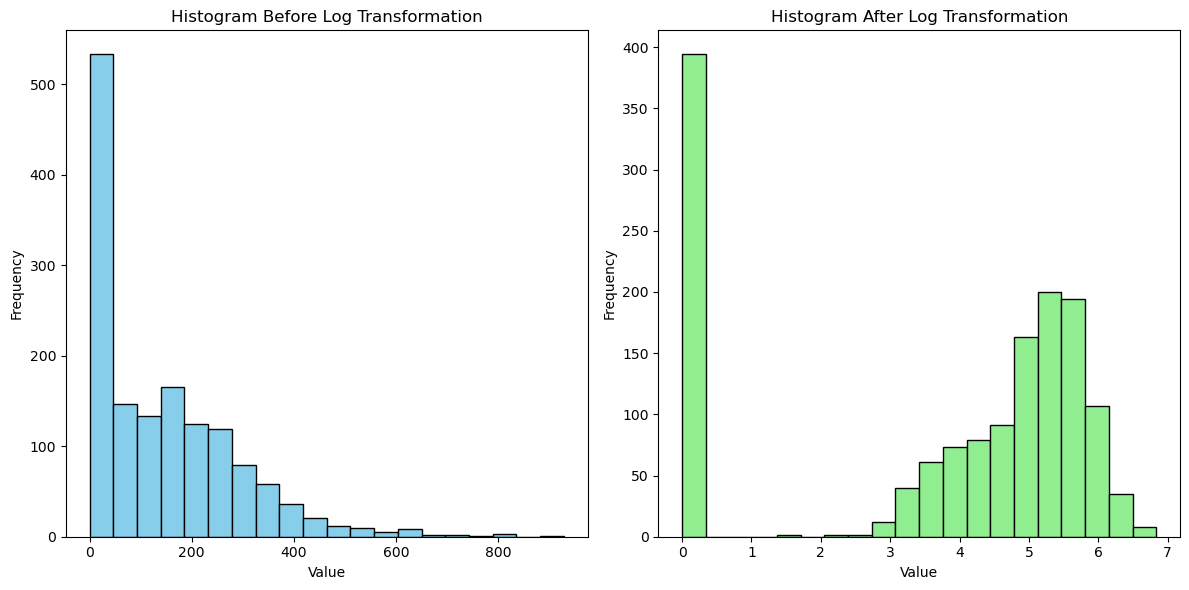

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming X_train is your DataFrame and 'Outdoor_Feature_DF' is the column to be transformed
# X_train = ...

# Plot histogram before log transformation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(X_train['Outdoor_Feature_DF'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram Before Log Transformation')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Apply log transformation
X_train['log_transformed_Outdoor_Feature_DF'] = np.log1p(X_train['Outdoor_Feature_DF'])

# Plot histogram after log transformation
plt.subplot(1, 2, 2)
plt.hist(X_train['log_transformed_Outdoor_Feature_DF'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Histogram After Log Transformation')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()


In [66]:


from scipy.stats import boxcox

# Assuming X_train is your DataFrame
# X_train = ...

# List of columns to be Box-Cox transformed
columns_to_transform = ['TotalBsmtSF', 'YearBuilt', 'GrLivArea', 'GarageArea', '1stFlrSF', 'Outdoor_Feature_DF', 'YearRemodAdd']

# Apply Box-Cox transformation to the specified columns
for column in columns_to_transform:
    X_train[column], _ = boxcox(X_train[column] + 1)  # Adding 1 to handle potential zero values

# Display the updated DataFrame
print(X_train.head())


    TotalBsmtSF     YearBuilt  GarageCars  LotArea  Fireplaces  OverallCond  \
Id                                                                            
1    198.284295  5.219183e+71           2     8450           0            5   
2    264.601145  3.865883e+71           2     9600           1            8   
3    209.206786  5.105134e+71           2    11250           1            5   
4    180.779930  1.932273e+71           3     9550           1            5   
5    246.150776  5.049005e+71           3    14260           1            5   

    GrLivArea  GarageArea  OverallQual   YearRemodAdd  1stFlrSF  \
Id                                                                
1    7.600483  204.517915            7  2.572317e+132  5.219622   
2    7.284379  177.329636            6  1.483257e+132  5.442275   
3    7.645779  222.579733            7  2.520729e+132  5.261495   
4    7.604738  232.664362            7  1.311106e+132  5.286701   
5    7.862154  288.451992            8  2.42

In [72]:
from scipy.stats import boxcox

# Assuming X_train is your DataFrame
# X_train = ...

# List of columns to be Box-Cox transformed
columns_to_transform = ['LotArea']

# Apply Box-Cox transformation to the specified columns
for column in columns_to_transform:
    X_train[column], _ = boxcox(X_train[column] + 1)  # Adding 1 to handle potential zero values

# Display the updated DataFrame
print(X_train.head())


    TotalBsmtSF     YearBuilt  GarageCars    LotArea  Fireplaces  OverallCond  \
Id                                                                              
1    198.284295  5.219183e+71           2  10.427530           0            5   
2    264.601145  3.865883e+71           2  10.596444           1            8   
3    209.206786  5.105134e+71           2  10.807339           1            5   
4    180.779930  1.932273e+71           3  10.589518           1            5   
5    246.150776  5.049005e+71           3  11.124528           1            5   

    GrLivArea  GarageArea  OverallQual   YearRemodAdd  1stFlrSF  \
Id                                                                
1    7.600483  204.517915            7  2.572317e+132  5.219622   
2    7.284379  177.329636            6  1.483257e+132  5.442275   
3    7.645779  222.579733            7  2.520729e+132  5.261495   
4    7.604738  232.664362            7  1.311106e+132  5.286701   
5    7.862154  288.451992     

In [69]:
#dropping finished basement sf in favour of area_with_finished_basement to reduce 0 count

#dropping wooddecksf and OpenPorchSF in favour of Outdoor_Feature_DF to reduce 0 count

#dropping area_with_finished_basement as it is similar to GrLivingArea

columns_to_drop = ['area_with_finished_basement']

# Drop the specified columns from X_train and X_test
X_train = X_train.drop(columns=columns_to_drop, axis=1)
X_test = X_test.drop(columns=columns_to_drop, axis=1)

In [70]:
#dropping finished basement sf in favour of area_with_finished_basement to reduce 0 count

#dropping wooddecksf and OpenPorchSF in favour of Outdoor_Feature_DF to reduce 0 count

#dropping area_with_finished_basement as it is similar to GrLivingArea

columns_to_drop = ['log_transformed_Outdoor_Feature_DF']

# Drop the specified columns from X_train and X_test
X_train = X_train.drop(columns=columns_to_drop, axis=1)


In [74]:
from scipy.stats import boxcox

# Assuming X_train is your DataFrame
# X_train = ...

# List of columns to be Box-Cox transformed
columns_to_transform = ['TotalBsmtSF']

# Apply Box-Cox transformation to the specified columns
for column in columns_to_transform:
    X_train[column], _ = boxcox(X_train[column] + 1)  # Adding 1 to handle potential zero values

# Display the updated DataFrame
print(X_train.head())

    TotalBsmtSF     YearBuilt  GarageCars    LotArea  Fireplaces  OverallCond  \
Id                                                                              
1    191.773147  5.219183e+71           2  10.427530           0            5   
2    255.355777  3.865883e+71           2  10.596444           1            8   
3    202.255318  5.105134e+71           2  10.807339           1            5   
4    174.965061  1.932273e+71           3  10.589518           1            5   
5    237.679950  5.049005e+71           3  11.124528           1            5   

    GrLivArea  GarageArea  OverallQual   YearRemodAdd  1stFlrSF  \
Id                                                                
1    7.600483  204.517915            7  2.572317e+132  5.219622   
2    7.284379  177.329636            6  1.483257e+132  5.442275   
3    7.645779  222.579733            7  2.520729e+132  5.261495   
4    7.604738  232.664362            7  1.311106e+132  5.286701   
5    7.862154  288.451992     

In [108]:
X_train.columns


Index(['TotalBsmtSF', 'YearBuilt', 'GarageCars', 'LotArea', 'Fireplaces',
       'OverallCond', 'GrLivArea', 'GarageArea', 'OverallQual', 'YearRemodAdd',
       '1stFlrSF', 'Outdoor_Feature_DF'],
      dtype='object')

In [114]:
import numpy as np

# Assuming X_train is your DataFrame
# X_train = ...

# List of columns to be log-transformed
columns_to_transform = ['TotalBsmtSF', 'YearBuilt', 'LotArea', 
       'OverallCond', 'GrLivArea', 'GarageArea',  'YearRemodAdd',
       '1stFlrSF', 'Outdoor_Feature_DF']

# Apply log transformation to the specified columns
X_train[columns_to_transform] = X_train[columns_to_transform].apply(lambda x: np.log1p(x))
X_test[columns_to_transform] = X_test[columns_to_transform].apply(lambda x: np.log1p(x))
# Display the updated DataFrame
print(X_train.head())

    TotalBsmtSF  YearBuilt  GarageCars   LotArea  Fireplaces  OverallCond  \
Id                                                                          
1      6.753438   7.602900           2  9.042040           0     1.791759   
2      7.141245   7.589336           2  9.169623           1     2.197225   
3      6.825460   7.601902           2  9.328212           1     1.791759   
4      6.629363   7.557995           3  9.164401           1     1.791759   
5      7.044033   7.601402           3  9.565284           1     1.791759   

    GrLivArea  GarageArea  OverallQual  YearRemodAdd  1stFlrSF  \
Id                                                               
1    7.444833    6.308098            7      7.602900  6.753438   
2    7.141245    6.133398            6      7.589336  7.141245   
3    7.488294    6.411818            7      7.602401  6.825460   
4    7.448916    6.466145            7      7.586296  6.869014   
5    7.695758    6.729824            8      7.601402  7.044033  

Your next task is to apply some feature engineering to prepare for using the XGBoost Estimator to predict house prices.

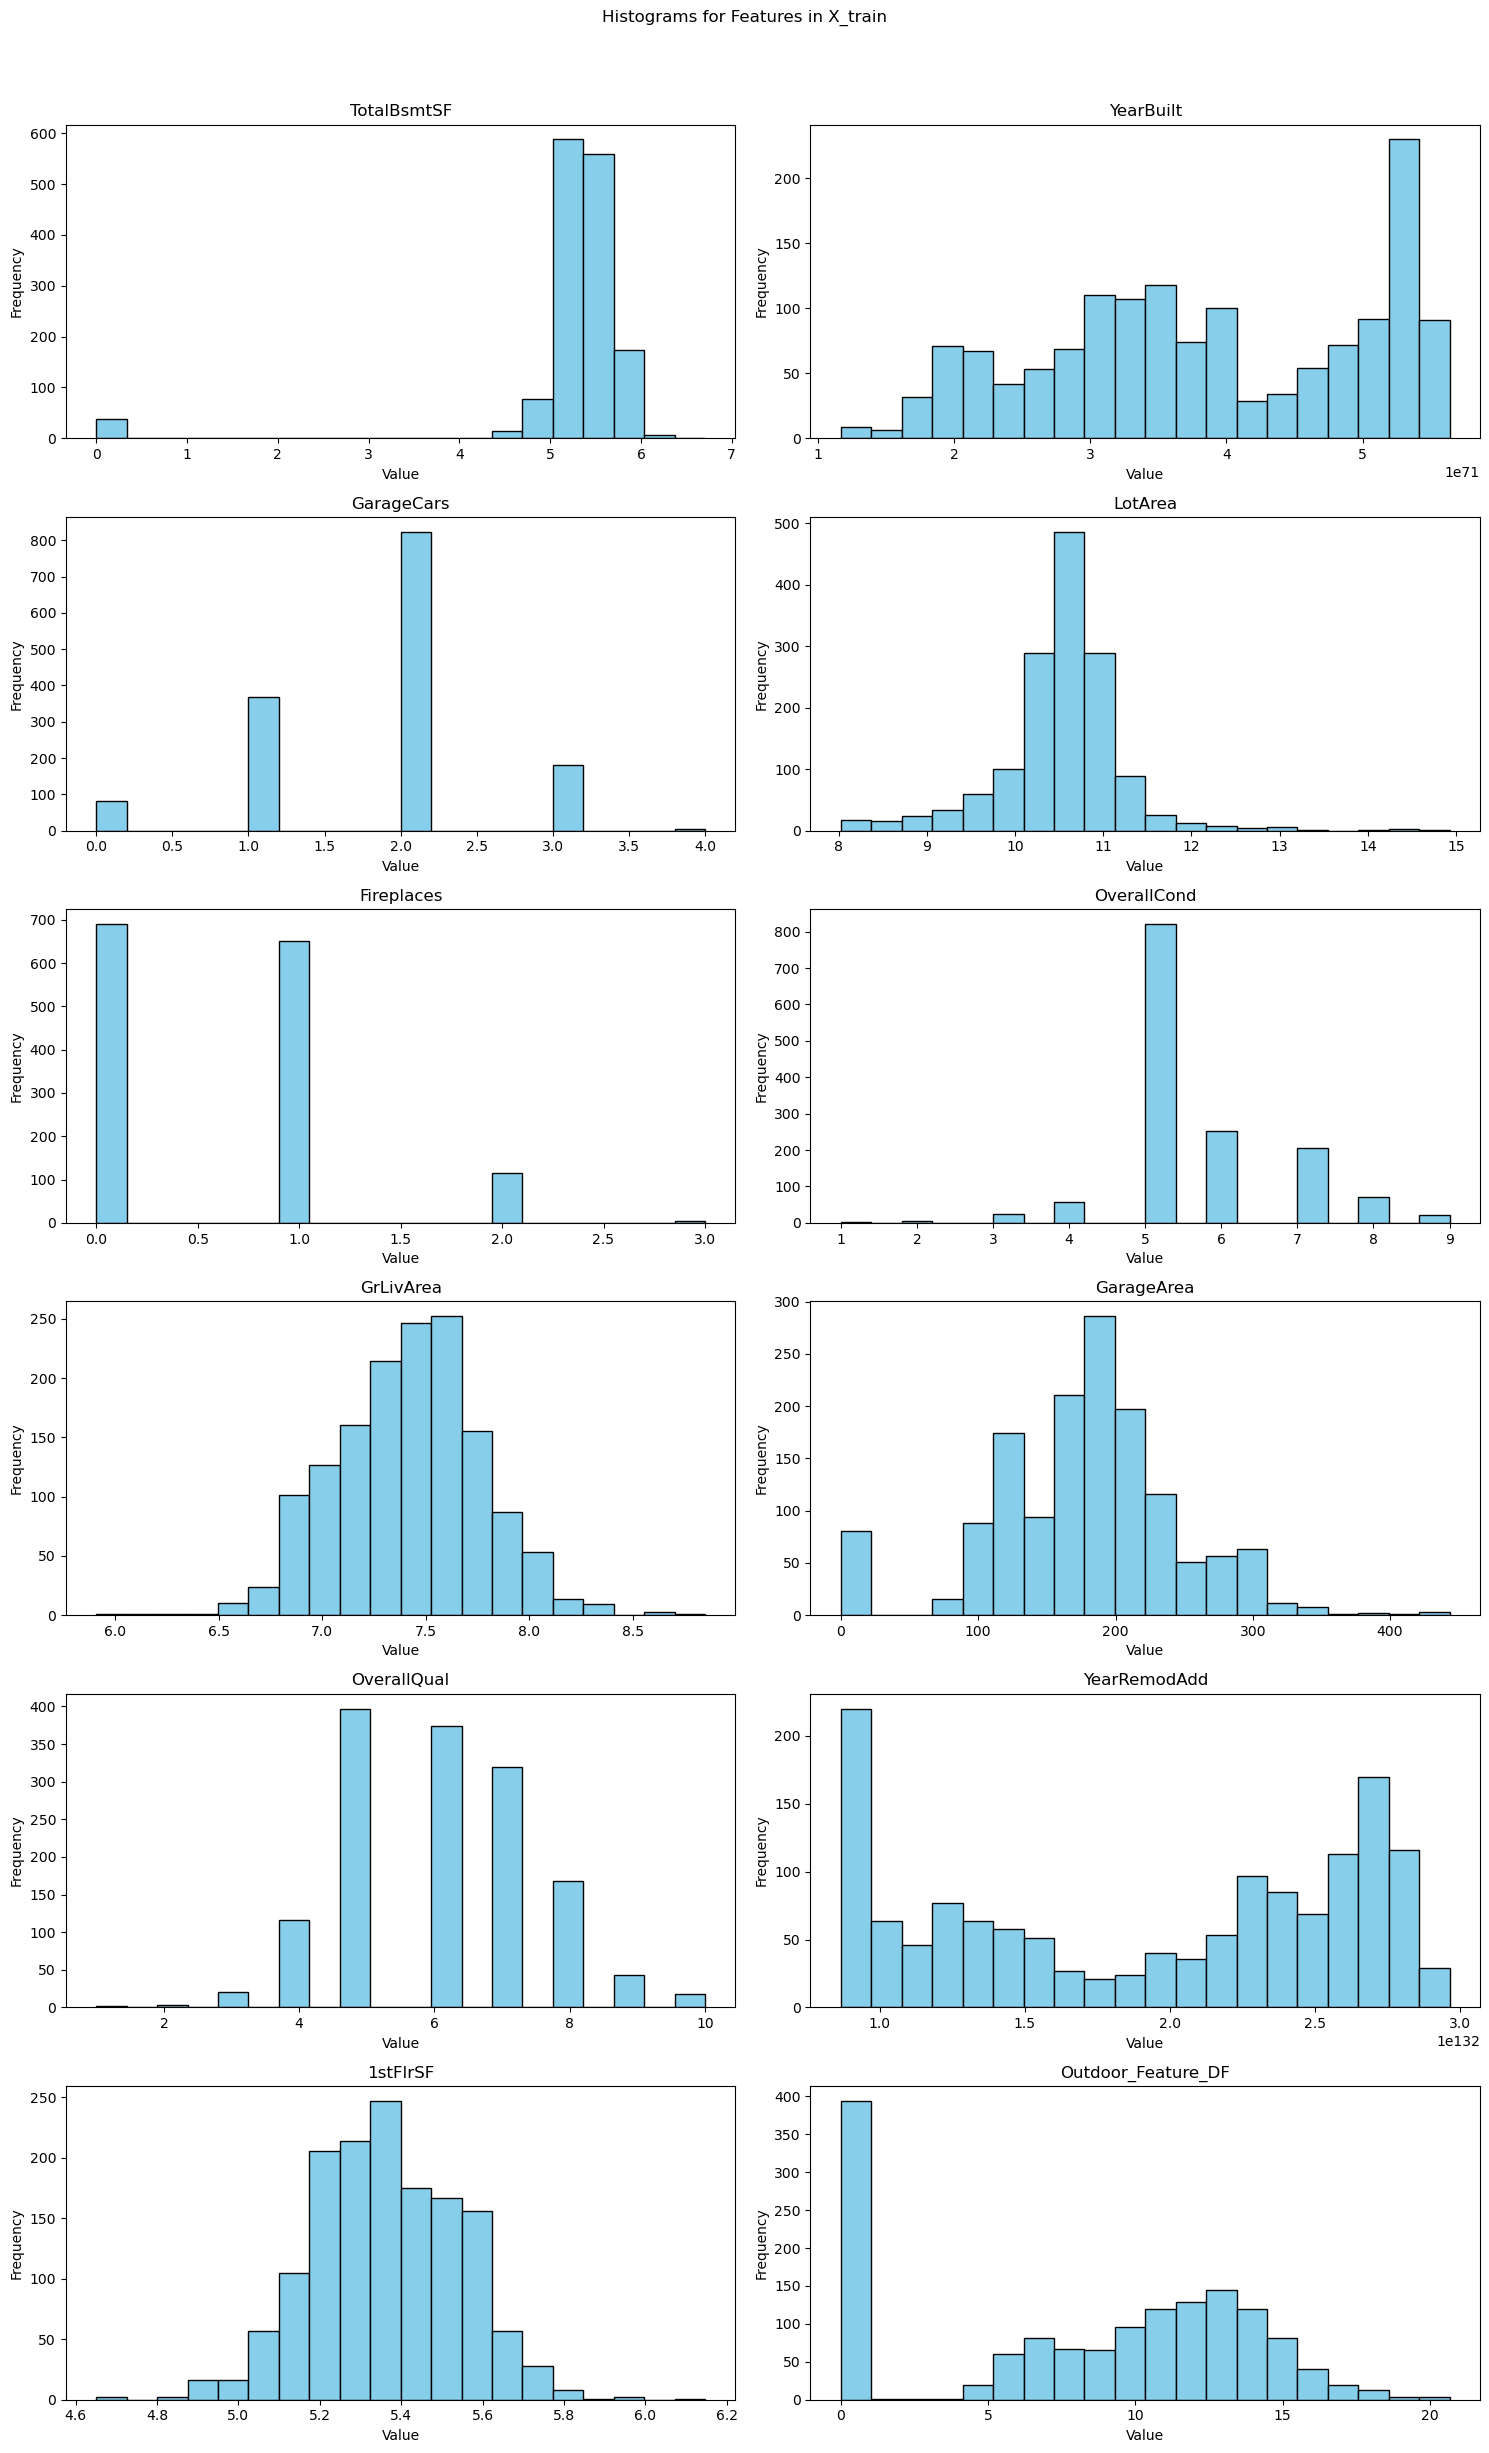

In [77]:
# Set the layout for subplots based on the number of features
num_features = X_train.shape[1]
num_rows = (num_features + 1) // 2  # Ensure at least two plots per row
num_cols = 2

# Create a figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
fig.suptitle('Histograms for Features in X_train', y=1.02)

# Flatten the 2D array of subplots for easier indexing
axes = axes.flatten()

# Plot histograms for each feature
for i in range(num_features):
    axes[i].hist(X_train.iloc[:, i], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(X_train.columns[i])
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

In [97]:
# Assuming X_train is your DataFrame
# X_train = ...

# Print the maximum values for all features
max_values = X_train.max(axis=0)

# Display the results
print("Max Values for Each Feature:")
print(max_values)


Max Values for Each Feature:
TotalBsmtSF            6.704532e+00
YearBuilt              5.637821e+71
GarageCars             4.000000e+00
LotArea                1.492612e+01
Fireplaces             3.000000e+00
OverallCond            9.000000e+00
GrLivArea              8.848184e+00
GarageArea             4.433085e+02
OverallQual            1.000000e+01
YearRemodAdd          2.963396e+132
1stFlrSF               6.146688e+00
Outdoor_Feature_DF     2.066586e+01
dtype: float64


For more on this fascinating aspect may I recommend the free on-line book ["*Feature Engineering and Selection: A Practical Approach for Predictive Models*"](http://www.feat.engineering/) by Max Kuhn and Kjell Johnson.
### <center style="background-color:Gainsboro; width:60%;">XGBoost estimator</center>
Note that for this competition we use the RMSLE evaluation metric, rather than the default metric, which for regression is the RMSE. For more on the peculiarities of the RMSLE see the Appendix below.

In [80]:
#=========================================================================
# XGBoost regression: 
# Parameters: 
# n_estimators  "Number of gradient boosted trees. Equivalent to number 
#                of boosting rounds."
# learning_rate "Boosting learning rate (also known as “eta”)"
# max_depth     "Maximum depth of a tree. Increasing this value will make 
#                the model more complex and more likely to overfit." 
#=========================================================================
regressor=xgb.XGBRegressor(eval_metric='rmsle')

#=========================================================================
# exhaustively search for the optimal hyperparameters
#=========================================================================
from sklearn.model_selection import GridSearchCV
# set up our search grid
param_grid = {"max_depth":    [4, 5],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

Can you use grid search to find the optimal hyper parameters?

In [94]:
regressor=xgb.XGBRegressor(eval_metric='rmsle')
regressor

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [95]:
regressor.fit(X_train, y_train)

XGBoostError: [11:31:28] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\common\../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`

In [115]:
clf= GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    cv=5,
    n_jobs=5,
    verbose=1
)

In [116]:
clf.fit(X_train, y_train)



Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmsle', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=Non...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=5,
             param_grid={'learning_rate': [0.01, 0.015], 'max_depth': [4, 5],
                         'n_estimators': [500, 600, 700]},
             verbose=1)

In [117]:
print(clf.best_params_)

{'learning_rate': 0.015, 'max_depth': 4, 'n_estimators': 700}


Now, can you setup a XGBoost Regressor object using your hyperparameters and fit it?

In [118]:


# Assuming regressor is defined as regressor = xgb.XGBRegressor(eval_metric='rmsle')

# Define the hyperparameters
hyperparameters = {'learning_rate': 0.015, 'max_depth': 4, 'n_estimators': 700}

# Set the hyperparameters for the regressor
regressor.set_params(**hyperparameters)


regressor.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Finally, can you run it on your test set?

array([129625.62 , 159056.48 , 175469.31 , ..., 181151.61 , 124884.805,
       236060.92 ], dtype=float32)

In [125]:
predictions = regressor.predict(X_test)

# Create a DataFrame with the predictions
solution_df = pd.DataFrame({'SalePrice': predictions})
solution_df.to_csv('predictions.csv', index=False)

In [ ]:
Can you score your solution offline and see how it does?

In [126]:
solution_df

,SalePrice
0,129625.617188
1,159056.484375
2,175469.312500
3,192734.796875
4,197954.031250
5,183004.125000
6,172948.750000
7,171761.671875
8,185310.125000
9,115692.835938


In [127]:
# read in the ground truth file
solution   = pd.read_csv('predictions.csv')
y_true     = solution["SalePrice"]

from sklearn.metrics import mean_squared_log_error
RMSLE = np.sqrt( mean_squared_log_error(y_true, predictions) )
print("The score is %.5f" % RMSLE )

The score is 0.00000


Finally, use the below block to prepare your submission

In [128]:
output = pd.DataFrame({"Id":test_data.index, "SalePrice":predictions})
output.to_csv('submission.csv', index=False)

### <center style="background-color:Gainsboro; width:60%;">Feature importance</center>
Let us also take a very quick look at the feature importance too:

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(regressor, max_num_features=8, ax=ax)
plt.show();

Where here the `F score` is a measure "*...based on the number of times a variable is selected for splitting, weighted by the squared improvement to the model as a result of each split, and averaged over all trees*." [1] 

Note that these importances are susceptible to small changes in the training data, and it is much better to make use of ["GPU accelerated SHAP values"](https://www.kaggle.com/carlmcbrideellis/gpu-accelerated-shap-values-jane-street-example), incorporated with version 1.3 of XGBoost.

Can you follow the above guide use SHAP values instead of F Score?

In [1]:
# code here

### <center style="background-color:Gainsboro; width:60%;">Appendix: The RMSLE evaluation metric</center>
From the competition [evaluation page](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation) we see that the metric we are using is the root mean squared logarithmic error (RMSLE), which is given by

$$ {\mathrm {RMSLE}}\,(y, \hat y) = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2} $$

where $\hat{y}_i$ is the predicted value of the target for instance $i$, and $y_i$
is the actual value of the target for instance $i$.

It is important to note that, unlike the RMSE, the RMSLE is asymmetric; penalizing much more the underestimated predictions than the overestimated predictions. For example, say the correct value is $y_i = 1000$, then underestimating by 600 is almost twice as bad as overestimating by 600:

In [ ]:
def RSLE(y_hat,y):
    return np.sqrt((np.log1p(y_hat) - np.log1p(y))**2)

print("The RMSLE score is %.3f" % RSLE( 400,1000) )
print("The RMSLE score is %.3f" % RSLE(1600,1000) )

The asymmetry arises because 

$$ \log (1 + \hat{y}_i) - \log (1 + y_i) =  \log \left( \frac{1 + \hat{y}_i}{1 + y_i} \right) $$

so we are essentially looking at ratios, rather than differences such as is the case of the RMSE. We can see the form that this asymmetry takes in the following plot, again using 1000 as our ground truth value:

In [ ]:
plt.rcParams["figure.figsize"] = (7, 4)
x = np.linspace(5,4000,100)
plt.plot(x, RSLE(x,1000))
plt.xlabel('prediction')
plt.ylabel('RMSLE')
plt.show()